In [32]:
import sys, os
import os
import torch
import torchvision.transforms as transforms

# home_dir = os.path.abspath(os.getcwd()+"/HPE")
home_dir = os.path.abspath(os.getcwd()+"/../")

sys.path.append(os.path.join(home_dir, 'lib'))
sys.path.append(home_dir)

from lib.models.backbones.vit import ViT
from lib.models.heads import UncertaintyDeconvDepthWiseChannelHead
from lib.models.heads import TopdownHeatmapSimpleHead
from lib.dataset.coco import COCODataset
from lib.core.config import config
from lib.core.config import update_config
# from lib.models.extra.vit_large_uncertainty_config import extra
from lib.models.extra.vit_huge_uncertainty_config import extra

from lib.models.uncertainty_pose import UncertaintyPose
from lib.models.vit_pose import ViTPose

from lib.utils.vis import display_heatamp, display_keypoints, display_keypoints_with_uncertainty, coco_info, skeleton_connection_info
import cv2
import numpy as np

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from PIL import Image


import gradio as gr
import os

### HPE #######################################################################
# Load config info
update_config(home_dir + '/experiments/coco/vit/vit_huge_uncertainty.yaml')

config.DATASET.TARGET_KEYPOINT = True
config.DATASET.TARGET_HEATMAP = True

config.TEST.USE_GT_BBOX = True

# Load model
from copy import deepcopy
## Backbone - ViT
backbone = ViT(
    img_size=extra["backbone"]["img_size"],
    patch_size=extra["backbone"]["patch_size"],
    embed_dim=extra["backbone"]["embed_dim"],
    in_channels=3,
    num_heads=extra["backbone"]["num_heads"],
    depth=extra["backbone"]["depth"],
    qkv_bias=True,
    drop_path_rate = extra["backbone"]["drop_path_rate"]
)

## HEAD - Heatmap Simple Head
deconv_head = TopdownHeatmapSimpleHead(
    in_channels=extra["keypoint_head"]["in_channels"],
    num_deconv_layers=extra["keypoint_head"]["num_deconv_layers"],
    num_deconv_filters=extra["keypoint_head"]["num_deconv_filters"],
    num_deconv_kernels=extra["keypoint_head"]["num_deconv_kernels"],
    extra=dict(final_conv_kernel=1),
    out_channels=17,
)

## Uncertainty head
uncertainty_head = UncertaintyDeconvDepthWiseChannelHead(
    extra["uncertainty_channel_head"], norm_cfg=dict(type="BN")
)
hpe_model = UncertaintyPose(backbone, deconv_head, uncertainty_head, config)
hpe_model_official = ViTPose(deepcopy(backbone), deepcopy(deconv_head))

hpe_model.eval()
hpe_model_official.eval()

# Load weight
checkpoint_path = home_dir + "/checkpoints/vit_huge_77_1.pth.tar" #"/checkpoints/vit_huge_uncertainty_77_1_AP.pth.tar"
checkpoint_official = home_dir + "/checkpoints/vitpose-h.pth" #checkpoints/vitpose_huge.pth"

hpe_model = hpe_model.custom_init_weights(hpe_model, checkpoint_path)
hpe_model_official.init_weights(checkpoint_official)

from lib.utils.transforms import get_affine_transform
from lib.utils.transforms import affine_transform
from pycocotools.coco import COCO

annFile='{}/annotations/person_keypoints_{}.json'.format("/data/coco", "val2017")
coco = COCO(annFile)


def box2cs(box):
    x, y, w, h = box[:4]
    return xywh2cs(x, y, w, h)

def xywh2cs(x, y, w, h):
    aspect_ratio = config.MODEL.IMAGE_SIZE[0] * 1.0 / config.MODEL.IMAGE_SIZE[1]
    pixel_std = 200

    center = np.zeros((2), dtype=np.float32)
    center[0] = x + w * 0.5
    center[1] = y + h * 0.5

    if w > aspect_ratio * h:
        h = w * 1.0 / aspect_ratio
    elif w < aspect_ratio * h:
        w = h * aspect_ratio
    scale = np.array([w * 1.0 / pixel_std, h * 1.0 / pixel_std], dtype=np.float32)
    if center[0] != -1:
        scale = scale * 1.25

    return center, scale

import matplotlib.patches as patches

def get_max_preds(heatmaps):
    """
    get predictions from score maps+
    heatmaps: numpy.ndarray([batch_size, num_joints, height, width])
    """
    assert isinstance(heatmaps, np.ndarray), "heatmaps should be numpy.ndarray"
    assert heatmaps.ndim == 4, "batch_images should be 4-ndim"
    N, K, _, W = heatmaps.shape
    heatmaps_reshaped = heatmaps.reshape((N, K, -1))
    idx = np.argmax(heatmaps_reshaped, 2).reshape((N, K, 1))
    maxvals = np.amax(heatmaps_reshaped, 2).reshape((N, K, 1))

    preds = np.tile(idx, (1, 1, 2)).astype(np.float32)
    preds[:, :, 0] = preds[:, :, 0] % W
    preds[:, :, 1] = preds[:, :, 1] // W

    preds = np.where(np.tile(maxvals, (1, 1, 2)) > 0.0, preds, -1)
    return preds, maxvals

print("Done!!!")

checkpoint path :  /home/yongju/Github/HPE_HOI/HPE/checkpoints/vit_huge_77_1.pth.tar
Succesfully init weights..
Please verify once again!!
Not applied "seed"
Not applied "epoch"
Not applied "mmcv_version"
Succesfully init weights..
The parameters of the original pretrained model and your model are identical!
loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
Done!!!


In [6]:
def draw_skeleton_origin_img(img, predict_keypoints, uncertainty, bbox, idx=0):
    # print(predict_keypoints)
    plt.imshow(img)
    plt.axis('off')
    ax = plt.gca()
    ax.set_autoscale_on(False)

    uncertainty_thr = 1.5
    print(bbox)
    ## 핵심 
    center, scale = box2cs([bbox[idx + i*len(preds_huge)] for i in range(4)])
    trans = get_affine_transform(center=center, scale=scale, rot=0, output_size=config.MODEL.IMAGE_SIZE, inv=1)
    ## 핵심  

    preds_huge_copy = deepcopy(predict_keypoints)

    # joint 17개 
    for i in range(17):
        preds_huge_copy[idx][i, 0:2] = affine_transform(predict_keypoints[idx][i, 0:2] * 4, trans)    
        
    pred_kp = preds_huge_copy[idx] 
    # print(pred_kp)
    uncertainty = uncertainty[idx]
    x = pred_kp[:,0]
    y = pred_kp[:,1]
    for i, sk in enumerate(skeleton_connection_info['SKELETON']):
        plt.plot(x[sk], y[sk], linewidth=2, color=skeleton_connection_info['COLOR'][i])
        print(x[sk],y[sk])

    plt.plot(x[uncertainty>uncertainty_thr], y[uncertainty>uncertainty_thr],'o',markersize=6, markerfacecolor=[1,0,0], markeredgecolor='k',markeredgewidth=2)
    plt.plot(x[uncertainty<uncertainty_thr], y[uncertainty<uncertainty_thr],'o',markersize=4, markerfacecolor=[1,1,1], markeredgecolor=[0,0,0], markeredgewidth=2)


# inference

In [41]:
def plot_skeleton(original_img, input_image_tensor, preds_huge, uncertainty,bbox,  idx=0):

    fig,ax1  = plt.subplots()

    original_w, original_h = original_img.size
    img_w, img_h = input_image_tensor.shape[2], input_image_tensor.shape[3]

    print("original_w, original_h:", original_w, original_h, ",img_w, img_h:", img_w, img_h)

    uncertainty_thr = 1.5
    ## 핵심
    #center, scale = box2cs([bbox[idx + i*len(preds_huge)] for i in range(4)])
    center, scale = box2cs([bbox[idx + i*len(preds_huge)] for i in range(4)])
    #trans = get_affine_transform(center=center, scale=scale, rot=0, output_size=config.MODEL.IMAGE_SIZE, inv=1)
    trans = get_affine_transform(center=center, scale=scale, rot=0, output_size=IMAGE_SIZE, inv=1)
    ## 핵심

    preds_huge_copy = deepcopy(preds_huge)

    # joint 17개
    for i in range(17):
        preds_huge_copy[idx][i, 0:2] = affine_transform(preds_huge[idx][i, 0:2] * 4, trans)

    pred_kp = preds_huge_copy[idx]

    uncertainty = uncertainty[idx]
    x = pred_kp[:,0]
    y = pred_kp[:,1]
    for i, sk in enumerate(skeleton_connection_info['SKELETON']):
        #plt.plot(x[sk], y[sk], linewidth=2, color=skeleton_connection_info['COLOR'][i])
        ax1.plot(x[sk], y[sk], linewidth=2, color=skeleton_connection_info['COLOR'][i])
        print(x[sk],y[sk])

    #plt.plot(x[uncertainty>uncertainty_thr], y[uncertainty>uncertainty_thr],'o',markersize=8, markerfacecolor=[1,0,0], markeredgecolor='k',markeredgewidth=2)
    #plt.plot(x[uncertainty<uncertainty_thr], y[uncertainty<uncertainty_thr],'o',markersize=4, markerfacecolor=[1,1,1], markeredgecolor=[0,0,0], markeredgewidth=2)
    ax1.plot(x[uncertainty>uncertainty_thr], y[uncertainty>uncertainty_thr],'o',markersize=6, markerfacecolor=[1,0,0], markeredgecolor='k',markeredgewidth=2)
    ax1.plot(x[uncertainty<uncertainty_thr], y[uncertainty<uncertainty_thr],'o',markersize=4, markerfacecolor=[1,1,1], markeredgecolor=[0,0,0], markeredgewidth=2)


    #ax1.imshow(original_img)
    ax1.imshow(input_image_tensor.permute(0,2,3,1)[0])
    plt.axis('off')

    fig.tight_layout()

    plt.savefig("./tmp1.png", dpi=200)
    fig1 = Image.open("./tmp1.png")

    return fig1

def get_box(coco_id):
    cat_id = coco.getCatIds(catNms=['person'])
    ann_id = coco.getAnnIds(imgIds=[int(coco_id)], catIds=cat_id, iscrowd=None)
    anns = coco.loadAnns(ids=ann_id[0])

    anns_bbox = [ int(x) for x in anns[0]['bbox'] ]
    #box = list(np.array([i.numpy() for i in anns_bbox]).reshape(-1))
    box = list(np.array([i for i in anns_bbox]).reshape(-1))
    print(box)
    return box

In [47]:
def infer_hpe(image,coco_id):
#     original_img = image

    img  = image.convert('RGB')  #Image.open(image_pth).convert('RGB')

    transform = transforms.Compose([ transforms.Resize((256,192)),
                                transforms.ToTensor() ] )

    input_img_tensor = transform(img)
    input_img_tensor = torch.unsqueeze(input_img_tensor,0)

    input_img_tensor = input_img_tensor.view(1,3,256,192)

    np.set_printoptions()  # 소수점 이하 자릿수 0, 지수 표현 비활성화

    with torch.no_grad():
        # pose_output = model.forward(img.cuda())
        pose_output = model.forward(input_img_tensor)
       # pose_output_official = model_official.forward(img)

        #g_t_preds, _1 = model.get_max_preds(heatmap.detach().cpu().numpy())

    keys_huge, uncertainty_huge, _, hm_huge = pose_output

    preds_huge, value_huge = get_max_preds(hm_huge.detach().cpu().numpy())

    # preds_huge_official, _ = get_max_preds(pose_output_official.detach().cpu().numpy())


    soft_plus = torch.nn.Softplus()

    uncertainty_map_huge = soft_plus(uncertainty_huge)

    if config.LOSS.USE_INDEXING:
        # kp_ = np.round(target.detach().cpu().numpy() / 4)
        # kp_ = np.round(keys_huge.detach().cpu().numpy())
        kp_ = np.round(preds_huge)

        x = np.clip(kp_[:, :, 0], 0, config.MODEL.HEATMAP_SIZE[0] - 1)
        y = np.clip(kp_[:, :, 1], 0, config.MODEL.HEATMAP_SIZE[1] - 1)

        # Uncertainty Map has 1 channel
        sigma_x = torch.diagonal(uncertainty_map_huge[:, 0, y, x], dim1=0, dim2=1).permute(
            1, 0
        )

        uncertainty_huge = torch.cat([sigma_x.unsqueeze(-1), sigma_x.unsqueeze(-1)], dim=-1)

    # get uncertainty 
    sigma_x = sigma_x.detach().cpu().numpy()

#    image = draw_skeleton_origin_img(original_img, preds_huge, sigma_x, box,  0)

#     image = plot_skeleton(original_img, input_img_tensor, preds_huge, sigma_x, box,  0)

    return image, preds_huge, sigma_x

[278, 25, 193, 239]
[278, 25, 193, 239]
[384.5521  389.57812] [270.15103 229.9427 ]
[389.57812 404.65625] [229.9427  174.65625]
[369.47397 369.47397] [255.0729  214.86458]
[369.47397 374.5    ] [214.86458 169.6302 ]
[404.65625 374.5    ] [174.65625 169.6302 ]
[419.73438 404.65625] [ 84.1875  174.65625]
[379.52603 374.5    ] [ 74.13542 169.6302 ]
[419.73438 379.52603] [84.1875  74.13542]
[419.73438 419.73438] [ 84.1875  174.65625]
[379.52603 369.47397] [ 74.13542 149.52605]
[419.73438 399.63022] [174.65625 119.3698 ]
[369.47397 369.47397] [149.52605 114.34375]
[399.63022 389.57812] [54.031254 54.031254]
[389.57812 399.63022] [64.083336 54.031254]
[389.57812 389.57812] [64.083336 54.031254]
[399.63022 409.68228] [54.031254 54.031254]
[389.57812 379.52603] [54.031254 49.005215]
[409.68228 419.73438] [54.031254 84.1875  ]
[379.52603 379.52603] [49.005215 74.13542 ]


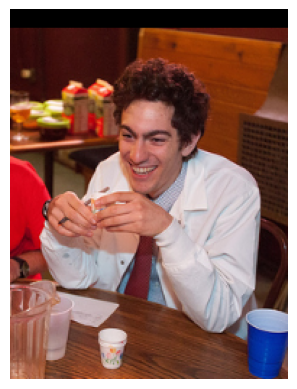

In [58]:
image_filename='/data/coco/val2017/000000579070.jpg'
coco_id = 579070

# transform = transforms.Compose([ transforms.Resize((256,192)),
#                                 transforms.ToTensor() ] )

# img = Image.open(image_filename)
# img = transform(img)
# img = torch.unsqueeze(img,0)
    
img_orig0 = cv2.imread(image_filename)
img_orig0 = cv2.cvtColor(img_orig0,cv2.COLOR_BGR2RGB)

box = get_box(coco_id)

idx = 0 
center, scale = box2cs([box[idx + i*len(img)] for i in range(4)])
trans = get_affine_transform(center=center, scale=scale, rot=0, output_size=config.MODEL.IMAGE_SIZE, inv=0)


input_img = cv2.warpAffine(
                img_orig0,
                trans,
                (int(config.MODEL.IMAGE_SIZE[0]), int(config.MODEL.IMAGE_SIZE[1])),
                flags=cv2.INTER_LINEAR,
            )

# input_img_tensor = img_orig0.view(1,3,256,192)

draw_skeleton_origin_img(input_img, preds_huge, sigma_x, box, 0)
plt.show()